## **Human approval as conditional edge**

* Here we defined a human function where we take in a boolean value and decide which node to continue with
* We used this function as a callable for conditional edge to get human approval for verification
* As the graph execution gets stopped midway and we need to take in human input for continuation, it requires checkpointer to store the graph state
* We use interrupt to pause the graph and take in human input
* We use Command to continue the graph by taking in human input

In [1]:
from typing_extensions import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

In [2]:
class State(TypedDict):
    input: str
    output: str
    messages: Annotated[list[str], add_messages]

class Input(TypedDict):
    input: str

class Output(TypedDict):
    output: str

In [4]:
checkpointer = MemorySaver()

builder1 = StateGraph(state_schema = State, input = Input, output = Output)

def node1(state: Input) -> State:
    return {"input": state["input"], "messages": [state["input"] + "1"]}

def human(state: State) -> Literal["node2", "node3"]:
    is_approved = interrupt({"question": "Do you want to continue in this route?", "message": state["messages"]})
    if is_approved:
        return "node2"
    else:
        return "node3"

def node2(state: Input) -> State:
    return {"messages": [state["input"] + "2"], "output": state["input"] + "3"}

def node3(state: Input) -> State:
    return {"messages": state["input"] + "4", "output": state["input"] + "5"}

builder1.add_node(node1, "node1")
builder1.add_node(node2, "node2")
builder1.add_node(node3, "node3")

builder1.add_edge(START, "node1")
builder1.add_conditional_edges("node1", human)
builder1.add_edge(["node2", "node3"], END)

graph1 = builder1.compile(checkpointer = checkpointer)
graph1.debug = True

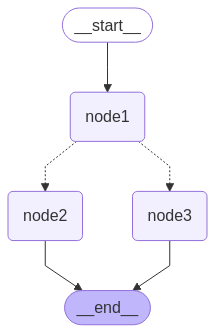

In [11]:
graph1

In [7]:
graph1.invoke({"input" : "0"}, {"configurable": {"thread_id": "1"}})

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}


In [8]:
graph1.invoke(Command(resume = True), {"configurable": {"thread_id": "1"}})

[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='506e0266-8117-4e97-a73b-e2e2f8190db7')]}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'input': '0'}
[2:writes] Finished step 2 with writes to 2 channels:
- messages -> ['02']
- output -> '03'
[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='506e0266-8117-4e97-a73b-e2e2f8190db7'),
              HumanMessage(content='02', additional_kwargs={}, response_metadata={}, id='7b4cf695-54d1-4759-b465-603dccda4c67')],
 'output': '03'}


{'output': '03'}

In [9]:
graph1.invoke({"input": "0"}, {"configurable": {"thread_id": "2"}})

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}


In [10]:
graph1.invoke(Command(resume = False), {"configurable": {"thread_id": "2"}})

[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='74aa6936-bc31-4f27-9fce-e81da6d587fe')]}
[2:tasks] Starting 1 task for step 2:
- node3 -> {'input': '0'}
[2:writes] Finished step 2 with writes to 2 channels:
- messages -> '04'
- output -> '05'
[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='74aa6936-bc31-4f27-9fce-e81da6d587fe'),
              HumanMessage(content='04', additional_kwargs={}, response_metadata={}, id='9a958502-db20-43f4-8fc5-0ed20d700ef9')],
 'output': '05'}


{'output': '05'}

In [12]:
for chunk in graph1.stream({"input": "0"}, {"configurable": {"thread_id": "3"}}, stream_mode = "updates"):
    print(chunk)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}
{'__interrupt__': (Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='3210308e-9aac-49ca-9457-68d00122ed7c')]}, resumable=True, ns=['node1:3731ebd5-69c4-ea47-043f-d27f44417ea6']),)}


In [15]:
graph1.get_state({"configurable": {"thread_id": "3"}}).next

('node1',)

In [16]:
for chunk in graph1.stream(Command(resume = True), {"configurable": {"thread_id": "3"}}, stream_mode = "updates"):
    print(chunk)

[1:tasks] Starting 1 task for step 1:
- node1 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e92785af-d006-4ba2-99af-d2973aa1fc6e')]}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'input': '0'}
{'node1': {'input': '0', 'messages': ['01']}}
[2:writes] Finished step 2 with writes to 2 channels:
- messages -> ['02']
- output -> '03'
[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e92785af-d006-4ba2-99af-d2973aa1fc6e'),
              HumanMessage(content='02', additional_kwargs={}, response_metadata={}, id='97d9327f-a603-434d-8a82-5f786164c922')],
 'output': '03'}
{'node2': {'messages': ['02'], 'output': '03'}}


## **Human approval as node**

* Previously, we got the human approval and used that value to route decide which node to go to (conditional edge)
* Here, we used the human approval as a node which will route to the appropriate node based on the human input
* Previously, we used resume parameter in Command class to get the data from the user. Here, we used that along with goto parameter which determines the node to go to next.
* The goto parameter of the Command class acts as a conditional edge for us in this case without the use of conditional edge
* Even if we try to restrict the response from the use to a boolean value and we passed an integer value, the code didn't return an error
* The data from the user can be of any type. We can even get a dictionary from the user with separate keys each of which can be extracted and used accrodingly
* By getting all sorts of data from the user in different keys, we can modify the functionality of the human node to either be an approval, state update or even multi-turn conversation

In [24]:
checkpointer2 = MemorySaver()

builder2 = StateGraph(state_schema = State, input = Input, output = Output)

def node12(state: Input) -> State:
    return {"input": state["input"], "messages": [state["input"] + "1"]}

def node22(state: Input) -> State:
    return {"messages": [state["input"] + "2"], "output": state["input"] + "3"}

def node32(state: Input) -> State:
    return {"messages": state["input"] + "4", "output": state["input"] + "5"}

def human2(state: State) -> Command[Literal["node22", "node32"]]:
    is_approved: bool = interrupt({"question": "Do you want to continue in this route?", "message": state["messages"]})
    if is_approved:
        return Command(goto = "node22")
    else:
        return Command(goto = "node32")

builder2.add_node(node12, "node12")
builder2.add_node(node22, "node22")
builder2.add_node(node32, "node32")
builder2.add_node(human2, "human2")

builder2.add_edge(START, "node12")
builder2.add_edge("node12", "human2")
builder2.add_edge(["node22", "node32"], END)

graph2 = builder2.compile(checkpointer = checkpointer2)
graph2.debug = True

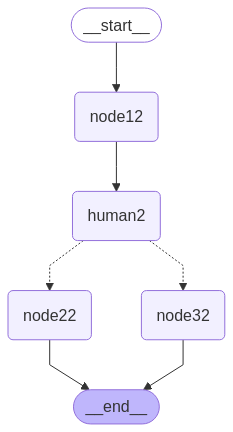

In [25]:
graph2

In [26]:
for chunk in graph2.stream({"input": "0"}, {"configurable": {"thread_id": "1"}}, stream_mode = "updates"):
    print(chunk)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node12 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e6afa0f6-e424-466b-af41-d3696648ea3e')]}
[2:tasks] Starting 1 task for step 2:
- human2 -> {'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e6afa0f6-e424-466b-af41-d3696648ea3e')]}
{'node12': {'input': '0', 'messages': ['01']}}
{'__interrupt__': (Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwa

In [27]:
graph2.get_state({"configurable": {"thread_id": "1"}}).next

('human2',)

In [ ]:
for chunk in graph2.stream(Command(resume = True), {"configurable": {"thread_id": "1"}}, stream_mode = "updates"):
    print(chunk)

[2:tasks] Starting 1 task for step 2:
- human2 -> {'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e6afa0f6-e424-466b-af41-d3696648ea3e')]}
[2:writes] Finished step 2 with writes to 0 channels:

[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e6afa0f6-e424-466b-af41-d3696648ea3e')]}
[3:tasks] Starting 1 task for step 3:
- node22 -> {'input': '0'}
{'human2': None}
[3:writes] Finished step 3 with writes to 2 channels:
- messages -> ['02']
- output -> '03'
[3:checkpoint] State at the end of step 3:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='e6afa0f6-e424-466b-af41-d3696648ea3e'),
              HumanMessage(content='02', additional_kwargs={}, response_metadata={}, id='e30e840c-29bf-431e-bda1-6c712aa7eecb')],
 'output': '03'}
{'node22': {'messages': ['02'], 'output': '03'}}


In [33]:
for chunk in graph2.stream({"input": "0"}, {"configurable": {"thread_id": "3"}}, stream_mode = "updates"):
    print(chunk)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node12 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='fff8c446-acfb-45c7-bcae-4db72bdf48d8')]}
[2:tasks] Starting 1 task for step 2:
- human2 -> {'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='fff8c446-acfb-45c7-bcae-4db72bdf48d8')]}
{'node12': {'input': '0', 'messages': ['01']}}
{'__interrupt__': (Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwa

In [34]:
for chunk in graph2.stream(Command(resume = 0), {"configurable": {"thread_id": "3"}}, stream_mode = "updates"):
    print(chunk)

[2:tasks] Starting 1 task for step 2:
- human2 -> {'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='fff8c446-acfb-45c7-bcae-4db72bdf48d8')]}
[2:writes] Finished step 2 with writes to 0 channels:

[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='fff8c446-acfb-45c7-bcae-4db72bdf48d8')]}
[3:tasks] Starting 1 task for step 3:
- node32 -> {'input': '0'}
{'human2': None}
[3:writes] Finished step 3 with writes to 2 channels:
- messages -> '04'
- output -> '05'
[3:checkpoint] State at the end of step 3:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='fff8c446-acfb-45c7-bcae-4db72bdf48d8'),
              HumanMessage(content='04', additional_kwargs={}, response_metadata={}, id='79d0fbf0-c2f9-4b1e-9994-5e5778fc6169')],
 'output': '05'}
{'node32': {'messages': '04', 'output': '05'}}


* As we can see here, when there is an interrupt, the graph won't return anything. The necessary information is present in the state of the graph
* We can use the state interrupt value for the specific configuration to pass to the user to get necessary information or confirmation

In [35]:
res = graph2.invoke({"input": "0"}, {"configurable": {"thread_id": "4"}})

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- node12 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '0'
- messages -> ['01']
[1:checkpoint] State at the end of step 1:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}
[2:tasks] Starting 1 task for step 2:
- human2 -> {'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}


In [37]:
print(res)

None


In [38]:
state = graph2.get_state({"configurable": {"thread_id": "4"}})

In [39]:
state

StateSnapshot(values={'input': '0', 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}, next=('human2',), config={'configurable': {'thread_id': '4', 'checkpoint_ns': '', 'checkpoint_id': '1f025241-a3d0-6603-8001-c3d407681edd'}}, metadata={'source': 'loop', 'writes': {'node12': None}, 'step': 1, 'parents': {}, 'thread_id': '4'}, created_at='2025-04-29T18:02:23.774259+00:00', parent_config={'configurable': {'thread_id': '4', 'checkpoint_ns': '', 'checkpoint_id': '1f025241-a3c4-6b01-8000-fec8d8224e05'}}, tasks=(PregelTask(id='5f5d32ea-be20-1182-aa3a-a470ef91ee05', name='human2', path=('__pregel_pull', 'human2'), error=None, interrupts=(Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}, resumable=True, ns=['human2:5f5d32ea-be20-1182-aa3a-a470ef91ee05']),), state=None

In [58]:
from pprint import pprint

pprint(state.values)
pprint(state.next)
pprint(state.config)
pprint(state.metadata)
pprint(state.created_at)
pprint(state.parent_config)

{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}
('human2',)
{'configurable': {'checkpoint_id': '1f025241-a3d0-6603-8001-c3d407681edd',
                  'checkpoint_ns': '',
                  'thread_id': '4'}}
{'parents': {},
 'source': 'loop',
 'step': 1,
 'thread_id': '4',
 'writes': {'node12': None}}
'2025-04-29T18:02:23.774259+00:00'
{'configurable': {'checkpoint_id': '1f025241-a3c4-6b01-8000-fec8d8224e05',
                  'checkpoint_ns': '',
                  'thread_id': '4'}}


In [59]:
pprint(state.tasks)
pprint(len(state.tasks))

(PregelTask(id='5f5d32ea-be20-1182-aa3a-a470ef91ee05', name='human2', path=('__pregel_pull', 'human2'), error=None, interrupts=(Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}, resumable=True, ns=['human2:5f5d32ea-be20-1182-aa3a-a470ef91ee05']),), state=None, result=None),)
1


In [60]:
state.tasks[0]

PregelTask(id='5f5d32ea-be20-1182-aa3a-a470ef91ee05', name='human2', path=('__pregel_pull', 'human2'), error=None, interrupts=(Interrupt(value={'question': 'Do you want to continue in this route?', 'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}, resumable=True, ns=['human2:5f5d32ea-be20-1182-aa3a-a470ef91ee05']),), state=None, result=None)

In [61]:
pprint(state.tasks[0].id)
pprint(state.tasks[0].name)
pprint(state.tasks[0].path)
pprint(state.tasks[0].error)

'5f5d32ea-be20-1182-aa3a-a470ef91ee05'
'human2'
('__pregel_pull', 'human2')
None


In [63]:
pprint(state.tasks[0].interrupts)
pprint(len(state.tasks[0].interrupts))

(Interrupt(value={'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')],
                  'question': 'Do you want to continue in this route?'},
           resumable=True,
           ns=['human2:5f5d32ea-be20-1182-aa3a-a470ef91ee05']),)
1


In [64]:
pprint(state.tasks[0].interrupts[0])

Interrupt(value={'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')],
                 'question': 'Do you want to continue in this route?'},
          resumable=True,
          ns=['human2:5f5d32ea-be20-1182-aa3a-a470ef91ee05'])


In [65]:
state.tasks[0].interrupts[0].value

{'question': 'Do you want to continue in this route?',
 'message': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='d4fd81bd-68ab-4d68-941b-52c63352a17d')]}

## **Human in the loop for updating the state**

* Here, we are taking a dictionary as input from the user with keys actions and conditionally data
* If user wants to continue, we move forward as is. If the user wants to update, we take the updated data and continue with that data
* As we can see in the invocation for thread ID 2, we started with input 0 but updated it with input 1

In [66]:
checkpointer3 = MemorySaver()

builder3 = StateGraph(state_schema = State, input = Input, output = Output)

def human3(state: Input) -> Command[Literal["node13", "node23"]]:
    data = interrupt({"question": "What do you want to do?", "options": ["continue", "update"], "messages" : state["input"]})

    if data["actions"] == "continue":
        return Command(goto = "node13")
    
    elif data["actions"] == "update":
        return Command(goto = "node23", update = {"input": data["update"]})
    
    else:
        raise ValueError("Invalid action")

def node13(state: Input):
    return {"messages": [state["input"] + "1"], "output": state["input"] + "2"}

def node23(state: Input):
    return {"messages": [state["input"] + "3"], "output": state["input"] + "4"}

builder3.add_node(human3, "human3")
builder3.add_node(node13, "node13")
builder3.add_node(node23, "node23")

builder3.add_edge(START, "human3")
builder3.add_edge(["node13", "node23"], END)

graph3 = builder3.compile(checkpointer = checkpointer3)
graph3.debug = True

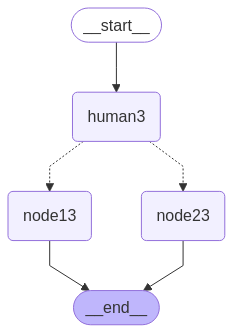

In [67]:
graph3

In [68]:
graph3.invoke({"input": "0"}, {"configurable": {"thread_id": "1"}})

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- human3 -> {'input': '0'}


In [69]:
graph3.get_state({"configurable": {"thread_id": "1"}}).tasks[0].interrupts[0].value

{'question': 'What do you want to do?',
 'options': ['continue', 'update'],
 'messages': '0'}

In [71]:
graph3.invoke(Command(resume = {"actions": "continue"}), {"configurable": {"thread_id": "1"}})

[1:tasks] Starting 1 task for step 1:
- human3 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 0 channels:

[1:checkpoint] State at the end of step 1:
{'input': '0', 'messages': []}
[2:tasks] Starting 1 task for step 2:
- node13 -> {'input': '0'}
[2:writes] Finished step 2 with writes to 2 channels:
- messages -> ['01']
- output -> '02'
[2:checkpoint] State at the end of step 2:
{'input': '0',
 'messages': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='7ba3fbbf-5469-4100-8783-1b1998f3c044')],
 'output': '02'}


{'output': '02'}

In [72]:
graph3.invoke({"input": "0"}, {"configurable": {"thread_id": "2"}})

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '0'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '0'
[0:checkpoint] State at the end of step 0:
{'input': '0', 'messages': []}
[1:tasks] Starting 1 task for step 1:
- human3 -> {'input': '0'}


In [73]:
graph3.get_state({"configurable": {"thread_id": "2"}}).tasks[0].interrupts[0].value

{'question': 'What do you want to do?',
 'options': ['continue', 'update'],
 'messages': '0'}

In [74]:
graph3.invoke(Command(resume = {"actions": "update", "update": "1"}), {"configurable": {"thread_id": "2"}})

[1:tasks] Starting 1 task for step 1:
- human3 -> {'input': '0'}
[1:writes] Finished step 1 with writes to 1 channel:
- input -> '1'
[1:checkpoint] State at the end of step 1:
{'input': '1', 'messages': []}
[2:tasks] Starting 1 task for step 2:
- node23 -> {'input': '1'}
[2:writes] Finished step 2 with writes to 2 channels:
- messages -> ['13']
- output -> '14'
[2:checkpoint] State at the end of step 2:
{'input': '1',
 'messages': [HumanMessage(content='13', additional_kwargs={}, response_metadata={}, id='953af4bb-c85b-4eb5-9150-cdf214759561')],
 'output': '14'}


{'output': '14'}